<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirement" data-toc-modified-id="Requirement-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Requirement</a></span></li><li><span><a href="#载入数据集" data-toc-modified-id="载入数据集-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>载入数据集</a></span></li><li><span><a href="#人脸识别" data-toc-modified-id="人脸识别-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>人脸识别</a></span><ul class="toc-item"><li><span><a href="#PCA-(Principal-Component-Analysis)" data-toc-modified-id="PCA-(Principal-Component-Analysis)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PCA (Principal Component Analysis)</a></span></li><li><span><a href="#FLD-(Fisher-Linear-Discriminant)" data-toc-modified-id="FLD-(Fisher-Linear-Discriminant)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>FLD (Fisher Linear Discriminant)</a></span></li></ul></li><li><span><a href="#预测" data-toc-modified-id="预测-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>预测</a></span><ul class="toc-item"><li><span><a href="#直接使用降维后的特征-（Euclidean）" data-toc-modified-id="直接使用降维后的特征-（Euclidean）-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>直接使用降维后的特征 （Euclidean）</a></span></li><li><span><a href="#使用-KNN-算法进行预测-（KNN）" data-toc-modified-id="使用-KNN-算法进行预测-（KNN）-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>使用 KNN 算法进行预测 （KNN）</a></span></li><li><span><a href="#使用-SVM-算法进行预测-（SVM）" data-toc-modified-id="使用-SVM-算法进行预测-（SVM）-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>使用 SVM 算法进行预测 （SVM）</a></span></li><li><span><a href="#使用全连接神经网络预测（MLP）" data-toc-modified-id="使用全连接神经网络预测（MLP）-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>使用全连接神经网络预测（MLP）</a></span></li></ul></li><li><span><a href="#可视化-（比较-PCA-和-LDA-降维效果）" data-toc-modified-id="可视化-（比较-PCA-和-LDA-降维效果）-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>可视化 （比较 PCA 和 LDA 降维效果）</a></span><ul class="toc-item"><li><span><a href="#PCA" data-toc-modified-id="PCA-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#FLD" data-toc-modified-id="FLD-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>FLD</a></span></li></ul></li><li><span><a href="#总结" data-toc-modified-id="总结-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>总结</a></span><ul class="toc-item"><li><span><a href="#实验结果" data-toc-modified-id="实验结果-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>实验结果</a></span></li><li><span><a href="#总结比较" data-toc-modified-id="总结比较-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>总结比较</a></span></li></ul></li></ul></div>

# Requirement
+ Python 3.7
+ numpy   科学计算库
+ sklearn  机器学习库
+ matplotlib  可视化库
+ torch   机器学习框架
+ PIL     图像处理库

In [1]:
%matplotlib inline
import torch
import warnings
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors  import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.datasets import fetch_lfw_people
from fetch_ORL_people import fetch_ORL_people
warnings.filterwarnings('ignore')

# 载入数据集
+ Labelled Faces in the Wild (LFW) 人脸数据集
    + fetch_lfw_people() 函数会检测是否存在数据集
        + 如果不存在数据集则会自动下载，但比较耗时
        + 也可手动下载，[下载地址](https://ndownloader.figshare.com/files/5976015)
    + 默认读取/下载的数据集路径为： ~\scikit_learn_data, 这里我指明了数据集路径
    + 为方便进行人脸识别，这里从原数据集中筛选出每个人至少有60张照片的数据
+ ORL 人脸数据集
    + 需要提前下载好数据集，[下载地址](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)


In [2]:
data_name = "ORL"  # 可选 "LFW" 或者 "ORL"
method = 'FLD'     # 可选 "PCA" 或者 "FLD"
if data_name == "LFW":
    faces = fetch_lfw_people('./Data/LFW', min_faces_per_person=60)
    n_components = 600
    n_neighbors = 10
elif data_name == "ORL":
    faces = fetch_ORL_people('./Data/ORL')
    n_components = 30
    n_neighbors = 1
else:
    raise ValueError(f'Invalid argument for data_name: {data_name}')
n_examples, img_row, img_col = faces.images.shape
n_classes = faces.target_names.size
print(f'Num examples={n_examples}, num classes={n_classes}, image shape={img_row}*{img_col}, feature shape={img_row*img_col}')

Num examples=400, num classes=40, image shape=56*46, feature shape=2576


faces 数据类存在如下属性：
+ data：图像向量数据，shpae=(n_examples, n_features)
+ images: 图像数据，shape=(n_examples, img_row, img_col)
+ targets：图像标签, 代表每张对应的图像的label (整型), shape=(n_examples,)
+ target_names：图像标签，代表每个label对应的人名 (字符串型), shape=(n_labels,)


In [3]:
'''绘图函数'''
def plot_faces(faces, name, row=3, col=3):
    fig, axes = plt.subplots(row, col, figsize=(row*10,col*10),subplot_kw={'xticks':[],'yticks':[]},
                            gridspec_kw=dict(hspace=0.1,wspace=0.1))
    for i,ax in enumerate(axes.flat):
        ax.imshow(faces[i].reshape(img_row, img_col),cmap='bone')
        ax.set(xlabel=f'{name[i]}')
    plt.show()

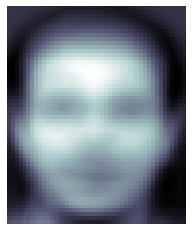

In [4]:
'''绘制平均脸'''
average_face = np.mean(faces.data, axis=0)
plt.imshow(average_face.reshape(img_row, img_col), cmap='bone')
plt.axis('off') # 不显示坐标轴
plt.show()

数据集划分：
+ 80% 训练集
+ 20% 测试集
+ 划分方式：层次划分，每个类别的训练集和测试集样本均匀

In [5]:
'''随机划分80%训练集，20%测试集'''
idx_train, idx_test = train_test_split(np.arange(faces.data.shape[0]), test_size=0.2, stratify=faces.target)
X_train, Y_train = faces.data[idx_train], faces.target[idx_train]
X_test, Y_test = faces.data[idx_test], faces.target[idx_test]

# 人脸识别
## PCA (Principal Component Analysis)
PCA的主要算法如下：
+ 给定训练集样本 $X= \{x_1, x_2,\cdots,x_N\}$，每个样本的维度为$D$，$X\in R^{N\times D}$
+ 计算样本每个特征的平均值 $\bar{x}=\frac{1}{N}\sum_{i=1}^{N}x_i$
+ 计算协方差矩阵 $\operatorname{Cov}(\boldsymbol{x})=\frac{1}{N} \sum_{i=1}^{N}\left(\boldsymbol{x}_{i}-\bar{x}\right)\left(\boldsymbol{x}_{i}-\bar{x}\right)^{T}$
+ 计算协方差矩阵的特征值 $\lambda_1, \lambda_2, \ldots, \lambda_D$和特征向量 $\xi_{1}, \xi_{2}, \ldots, \xi_D$
+ 对特征值和特征向量重新排列（特征值从大到小排列），使得$\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_D \geq 0$
+ 取特征值最大的 $d$ 个 特征值$\{\lambda_i\}_{i}^{d}$和对应特征向量 $\{\xi_i\}_{i}^{d}$
+ 令 $W=\{\xi_{1}, \xi_{2}, \ldots \xi_d\}$,显然$W \in R^{d \times D}$ 则投影后得到的新数据 $z_i= (x_i-\bar {x}) \cdot W^T, \forall i$，$Z\in R^{N\times d}$


In [6]:
'''由于数据较多, 因此使用随机方式求解 PCA '''
pca = PCA(svd_solver='full', n_components=n_components) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f'降维后的解释方差比率和 {pca.explained_variance_ratio_.sum()*100:.2f}%')

降维后的解释方差比率和 83.37%


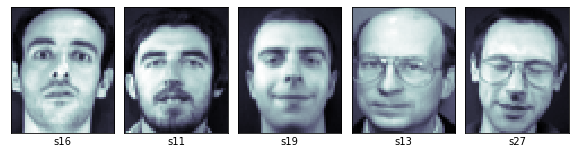

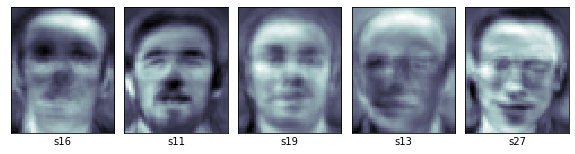

In [7]:
'''复原图片'''
X_train_estimate = np.dot(X_train_pca, pca.components_)
'''训练集中的原始图片'''
plot_faces(X_train, faces.target_names[Y_train], row=1,  col=5)
'''训练集复原后的图片'''
plot_faces(X_train_estimate, faces.target_names[Y_train], row=1, col=5)

## FLD (Fisher Linear Discriminant)
FLD的主要算法如下：
+ 给定训练集样本 $X= \{x_1, x_2,\cdots,x_N\}$，样本标签$Y=\{y_1, y_2,\cdots, y_N\}$，每个样本的维度为$D$，$X\in R^{N\times D}$
+ 计算类内散度矩阵 $S_w$
+ 计算类间散度矩阵 $S_b$
+ 计算矩阵 $S^{−1}_w \cdot S_b$
+ 计算 $S^{−1}_w \cdot S_b$ 最大的 $d$ 个 特征值$\{\lambda_i\}_{i}^{d}$和对应特征向量 $\{\xi_i\}_{i}^{d}$
+ 令 $W=\{\xi_{1}, \xi_{2}, \ldots \xi_d\}$，显然$W \in R^{d \times D}$ 则投影后得到的新数据 $z_i= (x_i-\bar {x}) \cdot W^T, \forall i$，$Z\in R^{N\times d}$

In [8]:
fld = LinearDiscriminantAnalysis(solver ='svd', n_components=min(n_classes-1, n_components))
X_train_fld = fld.fit_transform(X_train, Y_train)
X_test_fld = fld.transform(X_test)
print(f'降维后的解释方差比率和 {pca.explained_variance_ratio_.sum()*100:.2f}%')

降维后的解释方差比率和 83.37%


#  预测

In [9]:
if method == 'PCA':
    train_embedding = X_train_pca
    test_embedding = X_test_pca
elif method == "FLD":
    train_embedding = X_train_fld
    test_embedding = X_test_fld
else:
    raise ValueError(f'Invalid argument for method: {method}')

## 直接使用降维后的特征 （Euclidean）
+ 计算测试样本与训练样本的欧氏距离
+ 距离最近的训练样本的标签，即为该测试样本的标签


In [10]:
def EuclideanDistances(A, B, sqrt=False):
    '''求两个矩阵 A 和 B 每个向量两两之间的欧氏距离
        sqrt: False 是否使用开根号的欧氏距离 '''
    BT = B.transpose()
    # vecProd = A * BT
    vecProd = np.dot(A,BT)
    SqA =  A**2
    sumSqA = np.matrix(np.sum(SqA, axis=1))
    sumSqAEx = np.tile(sumSqA.transpose(), (1, vecProd.shape[1]))

    SqB = B**2
    sumSqB = np.sum(SqB, axis=1)
    sumSqBEx = np.tile(sumSqB, (vecProd.shape[0], 1))    
    SqED = sumSqBEx + sumSqAEx - 2*vecProd
    SqED[SqED<0] = 0.0   
    if sqrt:
        SqED = np.sqrt(SqED)
    return SqED

In [11]:
Euclidean_matrix = EuclideanDistances(test_embedding, train_embedding)
predict = np.argmin(Euclidean_matrix, axis=1)
predict_label = Y_train[predict].flatten()
acc = np.sum(predict_label == Y_test)/Y_test.size
print(f'Accuracy {acc*100:.2f}%')

Accuracy 95.00%


## 使用 KNN 算法进行预测 （KNN）
+ 使用降维后的训练样本作为输入，训练一个 KNN 分类器

In [12]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', n_jobs=10)
clf.fit(train_embedding, Y_train)
acc = clf.score(test_embedding, Y_test)
print(f'Accuracy {acc*100:.2f}%')

Accuracy 95.00%


## 使用 SVM 算法进行预测 （SVM）
+ 使用降维后的训练样本作为输入，训练一个 SVM 分类器

In [13]:
svc = SVC(kernel='rbf', class_weight='balanced', gamma='scale')
svc.fit(train_embedding, Y_train)
acc = svc.score(test_embedding, Y_test)
print(f'Accuracy {acc*100:.2f}%')

Accuracy 95.00%


## 使用全连接神经网络预测（MLP）
+ 将降维后的训练样本作为输入，训练神经网络的权重，初始化参数如下：
    + 三层神经网络，隐藏层神经元数为 (256, 128)
    + 迭代次数 150 次， 学习率 0.001， 权重衰减率 0.01， 优化器 Adam

In [14]:
class Model(nn.Module):
    def __init__(self, n_feat, n_class, dropout=0.0):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_feat, 512), 
            nn.Tanh(),
            nn.Linear(512, 128), 
            nn.Tanh(), 
            nn.Linear(128, n_class)
        )
        
    def forward(self, x):
        return self.layers(x)

def train(model, X_train, Y_train, epochs=100, lr=0.01, weight_decay=0.01):
    X_train = torch.FloatTensor(X_train)
    Y_train = torch.LongTensor(Y_train)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss_train = F.cross_entropy(output, Y_train)
        loss_train.backward()
        optimizer.step()
        
def test(model, X_test, Y_test):
    X_test = torch.FloatTensor(X_test)
    Y_test = torch.LongTensor(Y_test)
    model.eval()
    predict = model(X_test).argmax(1)
    correct = predict.eq(Y_test).double()
    correct = correct.sum()
    return correct / len(Y_test)


In [15]:
n_feat = train_embedding.shape[1]
n_class = np.max(faces.target) + 1
model = Model(n_feat, n_class)
train(model, train_embedding, Y_train)
acc = test(model, test_embedding, Y_test)
print(f'Accuracy {acc*100:.2f}%')

Accuracy 98.75%


# 可视化 （比较 PCA 和 LDA 降维效果）
为了方便可视化，这里将两个降维算法将原始数据降维到的二维的子空间中
## PCA

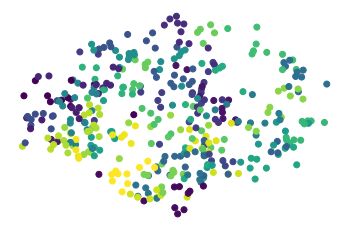

In [16]:
X = faces.data
Y = faces.target
pca = PCA(svd_solver='full', n_components=2) 
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=Y)
plt.axis('off')
plt.show()

## FLD

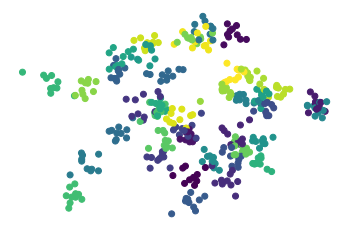

In [17]:
fld = LinearDiscriminantAnalysis(solver ='svd', n_components=2)
X_fld = fld.fit_transform(X, Y)
plt.scatter(X_fld[:, 0], X_fld[:, 1], marker='o', c=Y)
plt.axis('off')
plt.show()

显然，相对于 PCA， FLD在将数据降维到子空间的同时，还能使得不同类别的数据尽量分散，同一类别的数据尽量集中

# 总结
## 实验结果
以下汇总了在两个数据集中，两个降维算法在最优参数下，使用不同分类器得到的最好的分类准确率

+ LFW 数据集 


|Method|$d$|Euclidean|KNN|SVM|MLP|
|:-:|:-:|:-:|:-:|:-:|:-:|
|PCA|500|56.67%|57.41%|80.37%|81.11%|
|FLD|7|68.89%|69.26%|69.63%|71.11%|

+ ORL 数据集 


|Method|$d$|Euclidean|KNN|SVM|MLP|
|:-:|:-:|:-:|:-:|:-:|:-:|
|PCA|30|96.25%|96.25%|97.50%|97.50%|
|FLD|39|98.75%|98.75%|98.75%|98.75%|

## 总结比较
LDA用于降维，和PCA有很多相同，也有很多不同的地方，以下总结了两者的降维异同点。

相同点：

+ 两者均可以对数据进行降维。

+ 两者在降维时均使用了矩阵特征分解的思想。

+ 两者都假设数据符合高斯分布。

不同点：

+ LDA是有监督的降维方法，而PCA是无监督的降维方法

+ LDA降维最多降到类别数k-1的维数，而PCA没有这个限制。

+ LDA除了可以用于降维，还可以用于分类。

+ LDA选择分类性能最好的投影方向，而PCA选择样本点投影具有最大方差的方向。
